In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import time

from sympy import symbols, Symbol, Eq, nsolve, solve, sqrt

%run Functions.ipynb

### Market Prices

In [2]:
# Get market price space
def get_price_space(_initial_price_, _r_, _s_, _w_):

    price_space = pd.Series(np.arange(-_r_, _s_+1))
    price_space = price_space.apply(lambda x: _w_**x)
    price_space = price_space*_initial_price_

    return price_space

# Get sample market price movement
def get_price_movement(_price_space_, _p_, _W_, _T_, _seed_):
    
    initial_price_index = _price_space_[_price_space_ == _price_space_.median()].index[0]
    
    np.random.seed(_seed_)
    price_movement = np.random.uniform(0,1, _T_)
    price_movement = np.where(price_movement > _p_, 1, -1)
    price_movement = price_movement*_W_
    price_movement = price_movement.cumsum() + initial_price_index

    price_movement = _price_space_[price_movement].values
    price_movement = pd.concat([pd.Series([_price_space_.median()]), pd.Series(price_movement)]).reset_index(drop=True)

    return price_movement

### Bucket Characteristics

In [3]:
def get_bucket_space(_initial_price_, _min_price_, _max_price_, _theta_, _delta_):

    bucket_interval = _theta_*_delta_

    lower_bound = math.ceil(math.log(_min_price_/_initial_price_, bucket_interval))
    upper_bound = math.ceil(math.log(_max_price_/_initial_price_, bucket_interval))

    bucket_space = pd.Series(np.arange(lower_bound, upper_bound+1))
    bucket_space = bucket_space.apply(lambda x: bucket_interval**x)
    bucket_space = bucket_space*_initial_price_

    return bucket_space

### Exponential Utility Function

In [4]:
def get_utility(_x_, _risk_alpha_):
    
    if _risk_alpha_ == 0:
        return _x_
    
    else:
        return (1 - math.exp(-_risk_alpha_*_x_))/_risk_alpha_
    

## 5.1.2 Contract Price Updates

## Q-Learning Algorithm Setup

In [5]:
def generate_LP_action(_beta_, _T_, _seed_):

    # Generate a series of dealer action with probability of "explore" decreasing with the function exp(-beta*t)
    func = np.vectorize(lambda t: np.exp(-_beta_*t))
    dealer_action_prob = func(np.arange(0,_T_,1))

    np.random.seed(_seed_)
    dealer_action = np.random.uniform(0, 1, _T_)
    dealer_action = (dealer_action_prob >= dealer_action).astype(int).astype(str)
    dealer_action[dealer_action == '1'] = "explore"
    dealer_action[dealer_action == '0'] = "exploit"

    return dealer_action

In [6]:
def generate_trader_action(_p_, _k_, _seed_):

    np.random.seed(_seed_)
    trader_action = np.random.uniform(0, 1, _k_)
    trader_action = np.where(trader_action > _p_, "Buy", "Sell")

    return trader_action

In [7]:
def generate_q_matrix(_lower_q_, _upper_q_, _possible_range_, _no_LPs_, _seed_):

    np.random.seed(_seed_)
    Q_matrix = pd.DataFrame(np.random.uniform(_lower_q_, _upper_q_, size = (len(_possible_range_),_no_LPs_)), columns = ["LP_" + x for x in list(map(str, np.arange(_no_LPs_)))])
    Q_matrix.index = _possible_range_
    
    return(Q_matrix)

## Experiment Setup

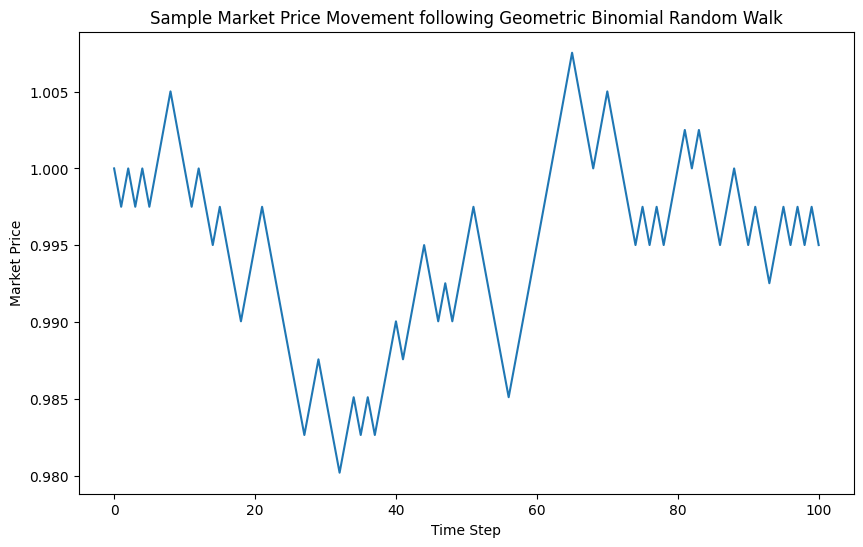

In [8]:
initial_price = 1
r = 5000
s = 5000
w = 1.0005

W = 5
T = 100
p = 0.5
risk_alpha = 0

theta = 1.002
delta = 1

price_space = get_price_space(initial_price, r,s,w)
bucket_space = get_bucket_space(initial_price, price_space.min(), price_space.max(), theta, delta)
possible_bucket_interval = np.arange(0,6,1)

# Plot
plt.figure(figsize=(10,6))
plt.plot(get_price_movement(price_space,p,W,T,5))
plt.title('Sample Market Price Movement following Geometric Binomial Random Walk')
plt.xlabel('Time Step')
plt.ylabel('Market Price')
plt.show()

In [9]:
# Q-learning Setup
no_experiment = 5000
alpha = 0.01
beta = 0.0008
print("LP's action in first 5000 rounds:\n",pd.Series(generate_LP_action(beta,no_experiment,0)[0:5000]).value_counts())

# Experiment Setup
no_LPs = 1

k = 10
price_impact = 0.00025
fees = 0.01

theta = 1.002
delta = 1

LP's action in first 5000 rounds:
 exploit    3764
explore    1236
dtype: int64


# Next Step: Find ways to make q-learning algorithm to converge

In [10]:
q_matrix = generate_q_matrix(0.25,0.28,possible_bucket_interval,no_LPs,0)
LP_action = [generate_LP_action(beta,no_experiment,0) for n in np.arange(0,no_LPs,1)]
PnL_history = [np.array([]) for n in np.arange(no_LPs)]
Action_history = [np.array([]) for n in np.arange(no_LPs)]

# Save greedy move to stop experiment
historical_greedy_bucket_interval = [np.array([]) for _ in np.arange(no_LPs)]

# Start experiment (we did not start with 0 because experiment_num is used as random seeds for price_movement and trade generation, using 0 in experiment will make all price_movement and trade the same)
for experiment_num in np.arange(1,no_experiment,1):

    if experiment_num%100 == 0: print(experiment_num)

    # Get price movement, and we solve the optimal liquidity provision
    price_movement = get_price_movement(price_space, p,W,T, no_experiment)

    # Environment Setup
    current_contract_price = Decimal(str(price_movement[0]))

    # UniSwap V3 Setup
    lp_dataframe = pd.DataFrame(columns = ['address','tick_lower','tick_upper','L'])
    current_state = {}
    fees_collected = {}

    # We need to save the initial contract price in order to determine the value of one L at the start of the period
    LP_holding_value = {}

    current_market_price = price_movement[0]
    current_bucket = bucket_space[bucket_space == 1].index[0]

    """
    LP Actions
    """
    for n in np.arange(no_LPs):

        # Dealer n choose to explore or exploit
        if LP_action[n][experiment_num] == "explore":
            
            # If explore, the LP choose a random interval from 0-11 and provides his liquidity at that interval around the last realized market price
            chosen_bucket_interval = np.random.choice(possible_bucket_interval)

        if LP_action[n][experiment_num] == "exploit":
            
            # If exploit, the LP choose the best action from 0-11 and provides his liquidity at that interval around the last realized market price
            chosen_bucket_interval = q_matrix.iloc[:,n].idxmax()

            # Save historical greedy bucket interval for dealer n into the corresponding list
            historical_greedy_bucket_interval[n] = np.append(historical_greedy_bucket_interval[n], chosen_bucket_interval)
        
        # Provide liquidity
        if chosen_bucket_interval % 2 == 0:
            lower_bucket_price = bucket_space[current_bucket - chosen_bucket_interval/2]
            upper_bucket_price = bucket_space[current_bucket + 1 + chosen_bucket_interval/2]
        
        else:
            lower_bucket_price = bucket_space[current_bucket - (chosen_bucket_interval+1)/2]
            upper_bucket_price = bucket_space[current_bucket + (chosen_bucket_interval+1)/2]

        # Solve for L, X and Y given the lower_bucket_price and upper_bucket_price
        L,X,Y = symbols('L,X,Y')
        eq1 = Eq(L*(1/sqrt(current_contract_price) - 1/sqrt(upper_bucket_price)), X)
        eq2 = Eq(L*(sqrt(current_contract_price) - sqrt(lower_bucket_price)), Y)
        eq3 = Eq(X*current_market_price + Y, 1)
        results = nsolve([eq1,eq2,eq3], [L,X,Y], [lower_bucket_price*upper_bucket_price, 0.5,0.5], prec = 50)

        current_state, current_contract_price, lp_dataframe, fees_collected = Provide_Liquidity(current_state, current_contract_price, lp_dataframe, fees_collected, 
                                                                                                "LP_"+str(n), lower_bucket_price, upper_bucket_price, results[0])
        LP_holding_value["LP_" + str(n)] = results[1]*current_market_price + results[2]
        Action_history[n] = np.append(Action_history[n], chosen_bucket_interval)
        
    # A general LP that provides LP across all bucket space to make sure trades can be executed in all range (the LP value does not matter because fees collected by LP only depends on price impact)
    current_state, current_contract_price, lp_dataframe, fees_collected = Provide_Liquidity(current_state, current_contract_price, lp_dataframe, fees_collected, 
                                                                                            "LP_x", bucket_space.min(), bucket_space.max(), 100)
        
    # Stop if greedy price for all dealers didn't change for 10 experiments
    if min([len(array) for array in historical_greedy_bucket_interval]) > 100 and max([np.std(array[-100:]) for array in historical_greedy_bucket_interval]) == 0:
        break


    # Loop over each period
    for t in range(T):

        # Updates market price
        current_market_price = price_movement[t] 

        """
        Trader Actions
        """
        trader_action = generate_trader_action(0.5,k,t*experiment_num)
        no_arbitrage_interval = [(1-fees)*current_market_price, (1/(1-fees))*current_market_price]

        for i in range(k):

            # If trader chooses to buy
            if trader_action[i] == "Buy":

                # First calculate the expected price impact of the trade
                final_contract_price = (1/(1-price_impact))*float(current_contract_price)

                # Then calculate the amount of token needed to be traded to reach desired price impact 
                # (we have checked the values with convergences by trading a very small amount until final current price reaches the expected impact price)
                current_state, current_contract_price, fees_collected, token0_to_trader = Swap_Token1_to_Token0(current_state, current_contract_price, lp_dataframe, fees_collected, 
                                                                                                                Get_Token_By_Price_Impact(current_state, current_contract_price, final_contract_price), fees)

                # After any trade, check if the current price is outside of no-arbitrage interval
                if current_contract_price > no_arbitrage_interval[1]:
                    current_state, current_contract_price, fees_collected, token0_to_trader = Swap_Token0_to_Token1(current_state, current_contract_price, lp_dataframe, fees_collected, 
                                                                                                                    Get_Token_By_Price_Impact(current_state, current_contract_price, no_arbitrage_interval[1]), fees)
                else:
                    continue
            

            # If trader chooses to sell
            else:

                # First calculate the expected price impact of the trade
                final_contract_price = (1-price_impact)*float(current_contract_price)

                # Then calculate the amount of token needed to be traded to reach desired price impact 
                # (we have checked the values with convergences by trading a very small amount until final current price reaches the expected impact price)
                current_state, current_contract_price, fees_collected, token0_to_trader = Swap_Token0_to_Token1(current_state, current_contract_price, lp_dataframe, fees_collected, 
                                                                                                                Get_Token_By_Price_Impact(current_state, current_contract_price, final_contract_price), fees)
            
                # Check if the current price is outside of no-arbitrage interval
                if current_contract_price < no_arbitrage_interval[0]:
                    current_state, current_contract_price, fees_collected, token0_to_trader = Swap_Token1_to_Token0(current_state, current_contract_price, lp_dataframe, fees_collected, 
                                                                                                                    Get_Token_By_Price_Impact(current_state, current_contract_price, no_arbitrage_interval[0]), fees)
                else:
                    continue
                    

    """
    Reward of LP
    """
    # Fees Collected
    fees_collected = pd.DataFrame.from_dict(fees_collected).T
    fees_collected.columns = ['token0','token1']
    fees_collected['value'] = fees_collected['token0']*current_market_price + fees_collected['token1']
    fees_collected = fees_collected.drop('LP_x')

    # Impermanent Loss and Profit and Loss
    lp_dataframe['PnL'] = 0
    lp_dataframe.set_index("address", inplace = True)
    lp_dataframe = lp_dataframe.drop('LP_x')
    lp_dataframe = lp_dataframe.join(fees_collected)

    for j in lp_dataframe.index:

        price_lower = Get_Price(lp_dataframe.loc[j,'tick_lower'])
        price_upper = Get_Price(lp_dataframe.loc[j,'tick_upper'])
        L  = Decimal(str(lp_dataframe.loc[j,'L']))
        
        lp_dataframe.loc[j,'PnL'] = float(Get_Value_From_Liquidity(L, price_lower, price_upper, current_contract_price, Decimal(str(current_market_price)))) -\
                                    LP_holding_value[j] + lp_dataframe.loc[j,'value']
        
        # Save history of PnL
        PnL_history[lp_dataframe.index.get_loc(j)] = np.append(PnL_history[lp_dataframe.index.get_loc(j)], lp_dataframe.loc[j,'PnL'])
            

    """
    Update q-matrix
    """
    for address in lp_dataframe.index:

        q_matrix.loc[chosen_bucket_interval,address] = alpha*get_utility(float(lp_dataframe.loc[address,'PnL']),risk_alpha) + (1-alpha)*q_matrix.loc[chosen_bucket_interval,address]

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100


In [11]:
q_matrix

,LP_0
0,0.194702
1,0.195398
2,0.166483
3,0.199256
4,0.194991
5,0.195372


In [12]:
print("Expected PnL is:", float(PnL_history[0][Action_history[0][:-1] == historical_greedy_bucket_interval[0][-1]].mean()))
print("Standard Deviation of PnL is:", PnL_history[0][Action_history[0][:-1] == historical_greedy_bucket_interval[0][-1]].astype(float).std())

Expected PnL is: 0.19921797410990227
Standard Deviation of PnL is: 0.044170735461922496


### Risk Alpha = 0

Expected PnL is: 0.20107770333166453
Standard Deviation of PnL is: 0.0440310949923372

### Risk Alpha = 5

Expected PnL is: 0.2062891118272519

Standard Deviation of PnL is: 0.07010719016287376

In [13]:
q_matrix.max()

LP_0    0.199256
dtype: float64

In [14]:
q_matrix.iloc[:,0].idxmax()

3